### Load libraries and packages

In [0]:
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.autograd import Variable

import numpy as np
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix, classification_report
import itertools

from tqdm import tqdm_notebook

In [0]:
import torchtext
from torchtext.vocab import Vectors

### Prepare dataset & set hyperparameters

In [0]:
use_cuda = True
if use_cuda and torch.cuda.is_available():
  DEVICE = 0
else:
  DEVICE = -1

In [0]:
TEXT = torchtext.data.Field()
LABEL = torchtext.data.Field(sequential=False, is_target=True)
train, val, test = torchtext.datasets.SST.splits(
    TEXT, LABEL, fine_grained=True)
TEXT.build_vocab(train)
LABEL.build_vocab(train)
"""mini-batch size of 50"""
train_iter, val_iter, test_iter = torchtext.data.BucketIterator.splits((train, val, test), batch_size=50, device=DEVICE, repeat=False)
"""We use the publicly available word2vec vectors that were trained on 100 billion words from Google News.
The vectors have dimensionality of 300 and were trained using the continuous bag-of-words architecture.
NB. Instead of pretrained word2vec vectors, we used the GloVe vectors, as provided by torchtext.""" 
TEXT.vocab.load_vectors('glove.840B.' + str(300) + 'd')

The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.
The `device` argument should be set by using `torch.device` or passing a string as an argument. This behavior will be deprecated soon and currently defaults to cpu.


In [0]:
BATCH_SIZE = train_iter.batch_size # 50
VOCAB_SIZE = len(TEXT.vocab) # |V| == 18282
EMBEDDING_DIM = TEXT.vocab.vectors.size()[1] # 300
N_CLASSES = len(LABEL.vocab) # 6
CLASSES = list(LABEL.vocab.stoi.values()) # [0, 2, 1, 4, 3, 5]
CLASSES.sort()

In [0]:
N_FEATURE_MAPS = 100
KERNEL_SIZES = [3,4,5] #in Kim2014: kernel sizes <--> filter windows
MODEL_VARIATION = "non-static"  #options: "rand", "static", "non-static", "multichannel"
LEARNING_RATE = 1e-4
EPOCHS = 20

### Define model & optimizer

In [0]:
# two alternative representations of convolutions; for details, see Goldberg, Y. (2017): Neural Network Methods for Natural Language Processing
REPRES = "vec_stacking" #options: "vec_stacking" and "vec_concat"

In [0]:
class CNN_Kim2014(nn.Module):
  
    def __init__(self, in_channels, out_channels, batch_size, model_variation):
        super(CNN_Kim2014, self).__init__()
        
        # initialize embedding matrix
        if model_variation == "rand":
          self.embeddings = nn.Embedding(VOCAB_SIZE, EMBEDDING_DIM)  #embedding matrix of size |V|×k
          self.embeddings.weight.data.uniform_(-0.1, 0.1)
        elif model_variation == "static":
          self.embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze=True)
        elif model_variation == "non-static":
          self.embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze=False)
        elif model_variation == "multichannel":
          """In [this] model variant, we experiment with having two 'channels' of word vectors -- one that is kept static throughout training
          and one that is fine-tuned via backpropagation"""
          self.static_embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze=True)
          self.non_static_embeddings = nn.Embedding.from_pretrained(TEXT.vocab.vectors, freeze=False)
        
        # multi-kernel convolution
        # NB. Padding is not specified in Kim2014
        if REPRES == "vec_stacking":
          if model_variation == "multichannel":
            """In the multichannel architecture, each filter (ie. kernel) is applied to both channels"""
            self.convs = nn.ModuleList([nn.Conv1d(in_channels = 2*in_channels, out_channels = out_channels, kernel_size = i, stride = 1, padding = 1 if i == 3 else 2, bias=True) for i in KERNEL_SIZES])
          else:
            self.convs = nn.ModuleList([nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = i, stride = 1, padding = 1 if i == 3 else 2, bias=True) for i in KERNEL_SIZES])
          
        elif REPRES == "vec_concat":
          if model_variation == "multichannel":
            self.convs = nn.ModuleList([nn.Conv1d(in_channels = 2*in_channels, out_channels = out_channels, kernel_size = i * EMBEDDING_DIM, stride = EMBEDDING_DIM, bias=True) for i in KERNEL_SIZES])
          else:
            self.convs = nn.ModuleList([nn.Conv1d(in_channels = in_channels, out_channels = out_channels, kernel_size = i * EMBEDDING_DIM, stride = EMBEDDING_DIM, bias=True) for i in KERNEL_SIZES])
          
        # dropout layer
        # at test time, there is no dropout
        self.dropout_train, self.dropout_test = nn.Dropout(p = 0.5), nn.Dropout(p = 0)
        
        # fully connected (linear) layer at the end
        self.linear = nn.Linear(in_features=out_channels, out_features=N_CLASSES, bias = True)
    
    def forward(self, x, train, model_variation):
      
        if model_variation == "multichannel":
          embed = torch.cat([self.static_embeddings(x), self.non_static_embeddings(x)], dim=2)
        else:
          embed = self.embeddings(x)  #input_shape × k where input_shape == max_sentence_length × batch_size, and k == EMBEDDING_DIM
        
        if REPRES == "vec_stacking":
          # reshape embedding matrix to batch_size × {# of channels}==k × max_sentence_length
          embed = embed.permute(1, 2, 0)
        elif REPRES == "vec_concat":
          # reshape embedding matrix to batch_size × {# of channels} × EMBEDDING_DIM*max_sentence_length
          if model_variation == "multichannel":
            embed = embed.view(embed.size(1), 2, -1)
          else:
            embed = embed.view(embed.size(1), 1, -1)
       
        # so we have h \in KERNEL_SIZES kernels to slide over the reshaped embedded matrix
        # each will produce N_FEATURE_MAPS feature maps of length (max_sentence_length - kernel_size + 1) (ie. "n-h+1")
        # we apply the relu activation function to each outputted feature map
        conv_embeddings = [F.relu(conv(embed)) for conv in self.convs]
        
        # then we concat these activated feature maps along the 3rd dim (ie. L_out, see https://pytorch.org/docs/stable/nn.html#conv1d)
        concat = torch.cat(conv_embeddings, dim = 2) #batch_size × N_FEATURE_MAPS × {concatted dim}
             
        # pooling layer: 1d max pooling to get the most active feature
        pool = F.max_pool1d(concat, concat.size(2)).squeeze(2)
        
        # dropout layer 
        if train:
          drop = self.dropout_train(pool)
        else:
          drop = self.dropout_test(pool)

        # fully connected (linear) layer
        out = self.linear(drop)
        log_probs = F.log_softmax(out, dim = 1)
        return log_probs

In [0]:
if REPRES == "vec_stacking":
  model = CNN_Kim2014(in_channels = EMBEDDING_DIM, out_channels = N_FEATURE_MAPS, batch_size = BATCH_SIZE, model_variation = MODEL_VARIATION)
elif REPRES == "vec_concat":  
  model = CNN_Kim2014(in_channels = 1, out_channels = N_FEATURE_MAPS, batch_size = BATCH_SIZE, model_variation = MODEL_VARIATION)
  
if use_cuda and torch.cuda.is_available():
    model.cuda()   

In [0]:
loss_fn = nn.NLLLoss() 
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)

### Util functions (train, evaluate, plot)

In [0]:
def evaluate(split_name):
    """
    split_name: val_iter or test_iter
    """
    
    correct, counter = 0, 0
    split_loss = 0
    y_true_list, y_pred_list = [], []
    for batch in split_name:
        if batch.label.size()[0] == BATCH_SIZE :
          x = Variable(batch.text) # batch × |V|
          y = Variable(batch.label)
          
          if use_cuda and torch.cuda.is_available():
            x = x.cuda()
            y = y.cuda()
          
          log_probs = model(x, train = False, model_variation = MODEL_VARIATION)

          split_loss += loss_fn(log_probs, y)

          _, predicted = torch.max(log_probs, dim=1)
          y_true_list += list(y.cpu().data.numpy())
          y_pred_list += list(predicted)
          for p, t in zip(predicted, y):
              counter += 1 
              if p.item() == t.item():
                  correct += 1
                
    accuracy = correct / counter
    split_loss /= len(val_iter)
    
    return accuracy, y_true_list, y_pred_list, split_loss.item()


In [0]:
def train(train_iter, val_iter, model, loss_fn, optimizer):
    train_losses, val_losses = [], []
    train_acc_list, val_acc_list = [], []
    for epoch in tqdm_notebook(range(EPOCHS)):
        epoch_loss = 0
        val_loss = 0
        for batch in train_iter:
            if batch.label.size()[0] == BATCH_SIZE:
                x = Variable(batch.text) # max sent length × batch_size
                y = Variable(batch.label)

                if use_cuda and torch.cuda.is_available():
                  x = x.cuda()
                  y = y.cuda()
                
                model.zero_grad()
                log_probs = model(x, train = True, model_variation = MODEL_VARIATION)
    
                loss = loss_fn(log_probs, y)
                loss.backward()
                optimizer.step()
          
                """We additionally constrain l2-norms of the weight vectors by rescaling w to have l2_norm(w) = s
                whenever l2_norm(w) > s after a gradient descent step."""  
                s = 3
                for i in range(model.linear.weight.size()[0]):
                  if model.linear.weight[i].norm().item() > s: #row norm, see cs224 lec
                    model.linear.weight[i].data = model.linear.weight[i].data / model.linear.weight[i].data.norm() * s
    
                epoch_loss += loss.item()
                
        accuracy_train, _, _, _ = evaluate(train_iter)
        accuracy_val, y_true_list_val, y_pred_list_val, split_loss = evaluate(val_iter)
        
        train_losses.append(epoch_loss / len(train_iter))
        val_losses.append(split_loss)
        train_acc_list.append(accuracy_train)
        val_acc_list.append(accuracy_val)
        print('Epoch {} avg. training loss: {}, val. loss: {} | training acc: {}, val acc: {}'.format(epoch, train_losses[epoch], val_losses[epoch], accuracy_train, accuracy_val))       
        

    y_pred_list_val = [y_pred_list_val[i].to("cpu").item() for i in range(len(y_pred_list_val))]
    confmat_val = confusion_matrix(y_true_list_val, y_pred_list_val[:len(y_true_list_val)], labels=CLASSES[1:])
    print("Confmat on valset:\n", confmat_val)
    return model, train_losses, val_losses, train_acc_list, val_acc_list


In [0]:
def plot_loss_fn(train_losses, val_losses, title):
    plt.plot(train_losses, label='train losses')
    plt.plot(val_losses, label='val losses')
    plt.xlabel('Epoch')
    plt.ylabel('Loss')
    plt.legend()
    plt.title(title)
    plt.figure()
    
def plot_acc_fn(train_acc, val_acc, title):
    plt.plot(train_acc, label='train acc')
    plt.plot(val_acc, label='val acc')
    plt.xlabel('Epoch')
    plt.ylabel('Avg. acc')
    plt.legend()
    plt.title(title)
    plt.figure()

def output_confusion_matrix(cm, filename):
    """
    Generate a confusion matrix,
    adapted from 
    https://scikit-learn.org/stable/auto_examples/model_selection/plot_confusion_matrix.html#sphx-glr-auto-examples-model-selection-plot-confusion-matrix-py
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=plt.cm.Reds)
    plt.colorbar()
    classes = ["- -", "-", "neut", "+", "+ +"]
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes)
    plt.yticks(tick_marks, classes)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")
    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    plt.savefig(filename) 

### Pre-test model, then train and evaluate on val. set

In [0]:
print("Run model on test data before training, just to see a before-and-after...")
accuracy_test, y_true_list_test, y_pred_list_test, split_loss = evaluate(test_iter)
print("Accuracy on test set: ", accuracy_test)

Run model on test data before training, just to see a before-and-after...
Accuracy on test set:  0.1918181818181818


Epoch 0 avg. training loss: 1.6426039432224475, val. loss: 1.486728549003601 | training acc: 0.3788235294117647, val acc: 0.3372727272727273
Epoch 1 avg. training loss: 1.5306874325400905, val. loss: 1.4325031042099 | training acc: 0.42164705882352943, val acc: 0.3654545454545455
Epoch 2 avg. training loss: 1.470125625008031, val. loss: 1.3898130655288696 | training acc: 0.4331764705882353, val acc: 0.38
Epoch 3 avg. training loss: 1.4098417375519958, val. loss: 1.3474946022033691 | training acc: 0.45905882352941174, val acc: 0.3972727272727273
Epoch 4 avg. training loss: 1.356919108775624, val. loss: 1.319174885749817 | training acc: 0.47458823529411764, val acc: 0.4118181818181818
Epoch 5 avg. training loss: 1.3093552331478275, val. loss: 1.2939953804016113 | training acc: 0.4983529411764706, val acc: 0.4109090909090909
Epoch 6 avg. training loss: 1.2702341219137985, val. loss: 1.2764756679534912 | training acc: 0.5229411764705882, val acc: 0.4127272727272727
Epoch 7 avg. training lo

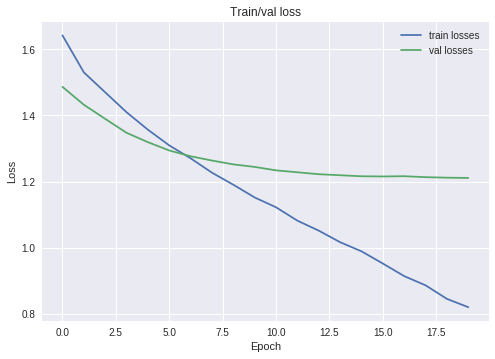

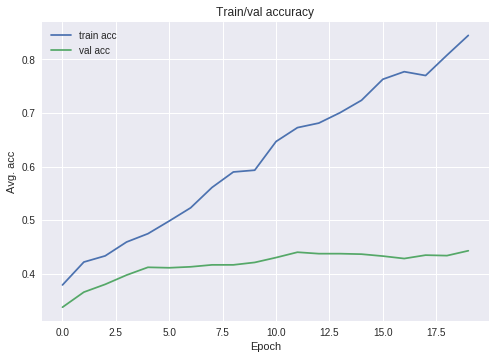

<Figure size 576x396 with 0 Axes>

In [0]:
model, train_losses, val_losses, train_acc_list, val_acc_list = train(train_iter, val_iter, model, loss_fn, optimizer)

plot_loss_fn(train_losses, val_losses, "Train/val loss")
plot_acc_fn(train_acc_list, val_acc_list, "Train/val accuracy")

 #### Evaluate on test set, report performance metrics

Accuracy on test set:  0.4659090909090909
[[320  79  30  78   1]
 [105 410  67   9  37]
 [128 176  69  11   5]
 [191  16  12 178   0]
 [ 24 188  17   1  48]]
              precision    recall  f1-score   support

           1       0.42      0.63      0.50       508
           2       0.47      0.65      0.55       628
           3       0.35      0.18      0.24       389
           4       0.64      0.45      0.53       397
           5       0.53      0.17      0.26       278

   micro avg       0.47      0.47      0.47      2200
   macro avg       0.48      0.42      0.41      2200
weighted avg       0.48      0.47      0.44      2200



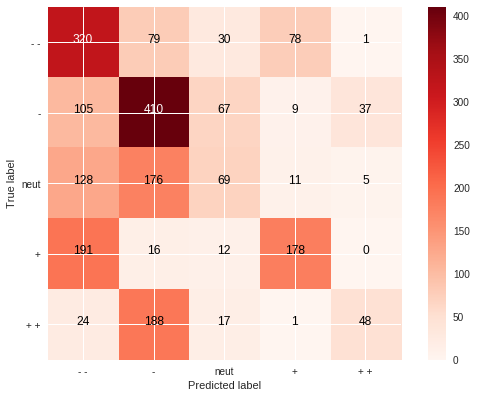

In [0]:
accuracy_test, y_true_list_test, y_pred_list_test, split_loss = evaluate(test_iter) 
print("Accuracy on test set: ", accuracy_test)
y_pred_list_test = [y_pred_list_test[i].to("cpu").item() for i in range(len(y_pred_list_test))]
confmat_test = confusion_matrix(y_true_list_test, y_pred_list_test[:len(y_true_list_test)], labels=CLASSES[1:])
print(confmat_test)
print(classification_report(y_true_list_test, y_pred_list_test[:len(y_true_list_test)], labels=CLASSES[1:]))
output_confusion_matrix(confmat_test, "cnn_confmat")